In [ ]:
!pip3 install matplotlib

In [111]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np

#### PREP

In [101]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.class_names = [
            'Grape___Esca_(Black_Measles)',
            'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
            'Grape___healthy',
            'Grape___Black_rot'
        ]
        
        for label, sub_dir in enumerate(os.listdir(root_dir)):
            sub_dir_path = os.path.join(root_dir, sub_dir)
            if os.path.isdir(sub_dir_path):
                for file_name in os.listdir(sub_dir_path):
                    self.image_paths.append(os.path.join(sub_dir_path, file_name))
                    self.labels.append(sub_dir)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        if isinstance(label, tuple):
            label = self._tensorize(label)
        elif isinstance(label, str):  # Handle case where label is a single class name
            label = torch.tensor(self.class_names.index(label))

        return image, label
    
    def _tensorize(self, class_names):
        return torch.tensor([self.class_names.index(class_name) for class_name in class_names])



In [102]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(root_dir='/Users/rishigurjar/Documents/verdus_testing/grape_dataset/train', transform=transform)
test_dataset = CustomDataset(root_dir='/Users/rishigurjar/Documents/verdus_testing/grape_dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [92]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Number of training samples: 7222
Number of testing samples: 1805


In [93]:
import torchvision

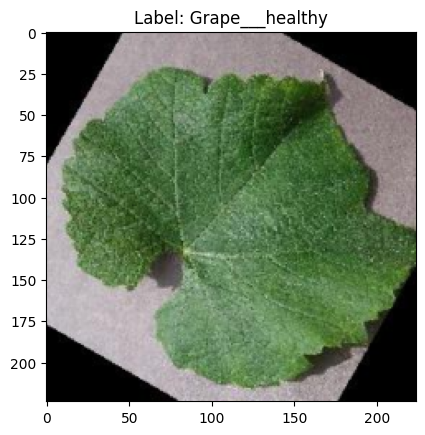

In [94]:
def show_image(image, label=None):
    image = image.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

# Get a sample from the training dataset
image, label = train_dataset[5224]
show_image(image, label)


#### NN

In [95]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [104]:
#Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # print("init", x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = F.relu(x)
        x = self.pool(x)
        # print("pool", x.shape)

        x = self.conv2(x)
        # print("conv2", x.shape)
        x = F.relu(x)
        x = self.pool(x)
        # print("pool", x.shape)
        x = torch.flatten(x, 1)
        # print("flatten", x.shape)

        x = self.fc1(x)
        # print("fc1", x.shape)
        x = F.relu(x)
        
        x = self.fc2(x)
        # print("fc2", x.shape)
        x = F.relu(x)

        x = self.fc3(x)

        return x

In [105]:
net = Net()
images, labels = next(iter(train_loader))
outputs = net(images)
print(f"Output shape: {outputs.shape}") # Should be [32, 10] since batch size is 32 and there are 10 classes

# torch.Size([32, 6, 110, 110]) = [# of images, # of channels, height, width of each image]

Output shape: torch.Size([32, 10])


In [106]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#train
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        print(f'[{epoch + 1}, {running_loss:.3f}]')

print('Finished Training')

#### EVAL

In [116]:
#eval
correct = 0
total = 0
train_losses = []
num_epochs = 10 

for epoch in range(num_epochs):
    running_train_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}')


print(f"Accuracy of the network on the test images: {100 * correct / total:.2f}%")


Epoch [1/10], Train Loss: 0.4955
Epoch [2/10], Train Loss: 0.3430
Epoch [3/10], Train Loss: 0.2817
Epoch [4/10], Train Loss: 0.2385
Epoch [5/10], Train Loss: 0.2006
Epoch [6/10], Train Loss: 0.1860
Epoch [7/10], Train Loss: 0.1751
Epoch [8/10], Train Loss: 0.1499
Epoch [9/10], Train Loss: 0.1411


In [114]:
import numpy as np

# Choose a sample image
sample_image, _ = next(iter(test_loader))

# Visualize activation maps for a sample image
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Attach hooks to the layers you want to visualize
net.conv1.register_forward_hook(get_activation('conv1'))

# Forward pass
output = net(sample_image)

# Extract and visualize activations
act = activation['conv1'].squeeze().cpu()
fig, axes = plt.subplots(4, 4, figsize=(220, 220))
for i, ax in enumerate(axes.flat):
    ax.imshow(act[i], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Activation Map {i+1}')
plt.tight_layout()
plt.show()


TypeError: Invalid shape (6, 220, 220) for image data